<h1>GoJek App Reviewer</h1>
<b>Yeremia Maydinata Narana || 5026221068</b>

So this is my first time doing EDA and NLP, so please be kind. I will try to explain every step that I do. So let's get started.

<h2>#1 Scrapping Data</h2>  
Scrapping data from Google Play Store using <b>google-play-scraper</b> library.

In [1]:
!pip install google_play_scraper -q
!pip install textblob -q
!pip install seaborn -q

You should consider upgrading via the 'C:\Users\PC GAMING\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\PC GAMING\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\PC GAMING\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

In [3]:
#Android App Gojek from Google Play at
#https://play.google.com/store/apps/details?id=com.gojek.app
#The apps ID found in the link after id=com.gojek.app

from google_play_scraper import app, Sort, reviews_all

gojek_reviews = reviews_all(
    'com.gojek.app',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [4]:
df_gjkrev = pd.DataFrame(np.array(gojek_reviews),columns=['content'])
df_gjkrev = df_gjkrev.join(pd.DataFrame(df_gjkrev.pop('content').tolist()))

In [5]:
df_gjkrev
df_gjkrev.info()
df_gjkrev['score'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226081 entries, 0 to 226080
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              226081 non-null  object        
 1   userName              226081 non-null  object        
 2   userImage             226081 non-null  object        
 3   content               226046 non-null  object        
 4   score                 226081 non-null  int64         
 5   thumbsUpCount         226081 non-null  int64         
 6   reviewCreatedVersion  193460 non-null  object        
 7   at                    226081 non-null  datetime64[ns]
 8   replyContent          34991 non-null   object        
 9   repliedAt             34991 non-null   datetime64[ns]
 10  appVersion            193460 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 19.0+ MB


score
5    123191
1     51041
4     21972
3     15506
2     14371
Name: count, dtype: int64

In [6]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_gjkrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

content  score  \
0                                          still good app      5   
1       Gojek should improve their maps. Please do it ...      5   
2                          price still higher than others      4   
3       The service is getting worse in 2025. Food del...      2   
4                                                   cukup      2   
...                                                   ...    ...   
226076                                      Love this app      5   
226077                              Akhirnya keluar juga!      5   
226078                                            Finally      5   
226079                                            Helpful      4   
226080                                     Usefull banget      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0               5.31.2 2025-09-16 07:35:57   
1                   0                 None 2025-09-16 07:23:13   
2                   0               5.31.2 2025-09-16 05:30:38   
3                   0               5.31.2 2025-09-15 19:07:03   
4                   0               4.31.1 2025-09-15 18:40:57   
...               ...                  ...                 ...   
226076              0                1.0.1 2014-12-31 04:11:06   
226077              0                1.0.1 2014-12-24 22:20:26   
226078              0                1.0.1 2014-12-23 12:04:16   
226079              0                 None 2014-12-20 23:41:52   
226080              1                 None 2014-12-19 22:00:21   

                                             replyContent           repliedAt  
0                                                    None                 NaT  
1       Hi, Marcelia. Ensure you've permitted the loca... 2024-09-02 12:26:38  
2                                                    None                 NaT  
3       Hi @wlesmana, we're sorry for the inconvenienc... 2025-09-15 22:41:26  
4                                                    None                 NaT  
...                                                   ...                 ...  
226076                                               None                 NaT  
226077                                               None                 NaT  
226078                                               None                 NaT  
226079                                               None                 NaT  
226080                                               None                 NaT  

[226081 rows x 7 columns]

<h2>#2 Preprocessing Data</h2> 

<b>Sentiment before Preprocessing</b>

In [7]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_gjkrev['sentiment_rating'] = df_gjkrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [8]:
from textblob import TextBlob
df_gjkrev['sentiment_polarity'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_gjkrev['sentiment_subjective'] = df_gjkrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

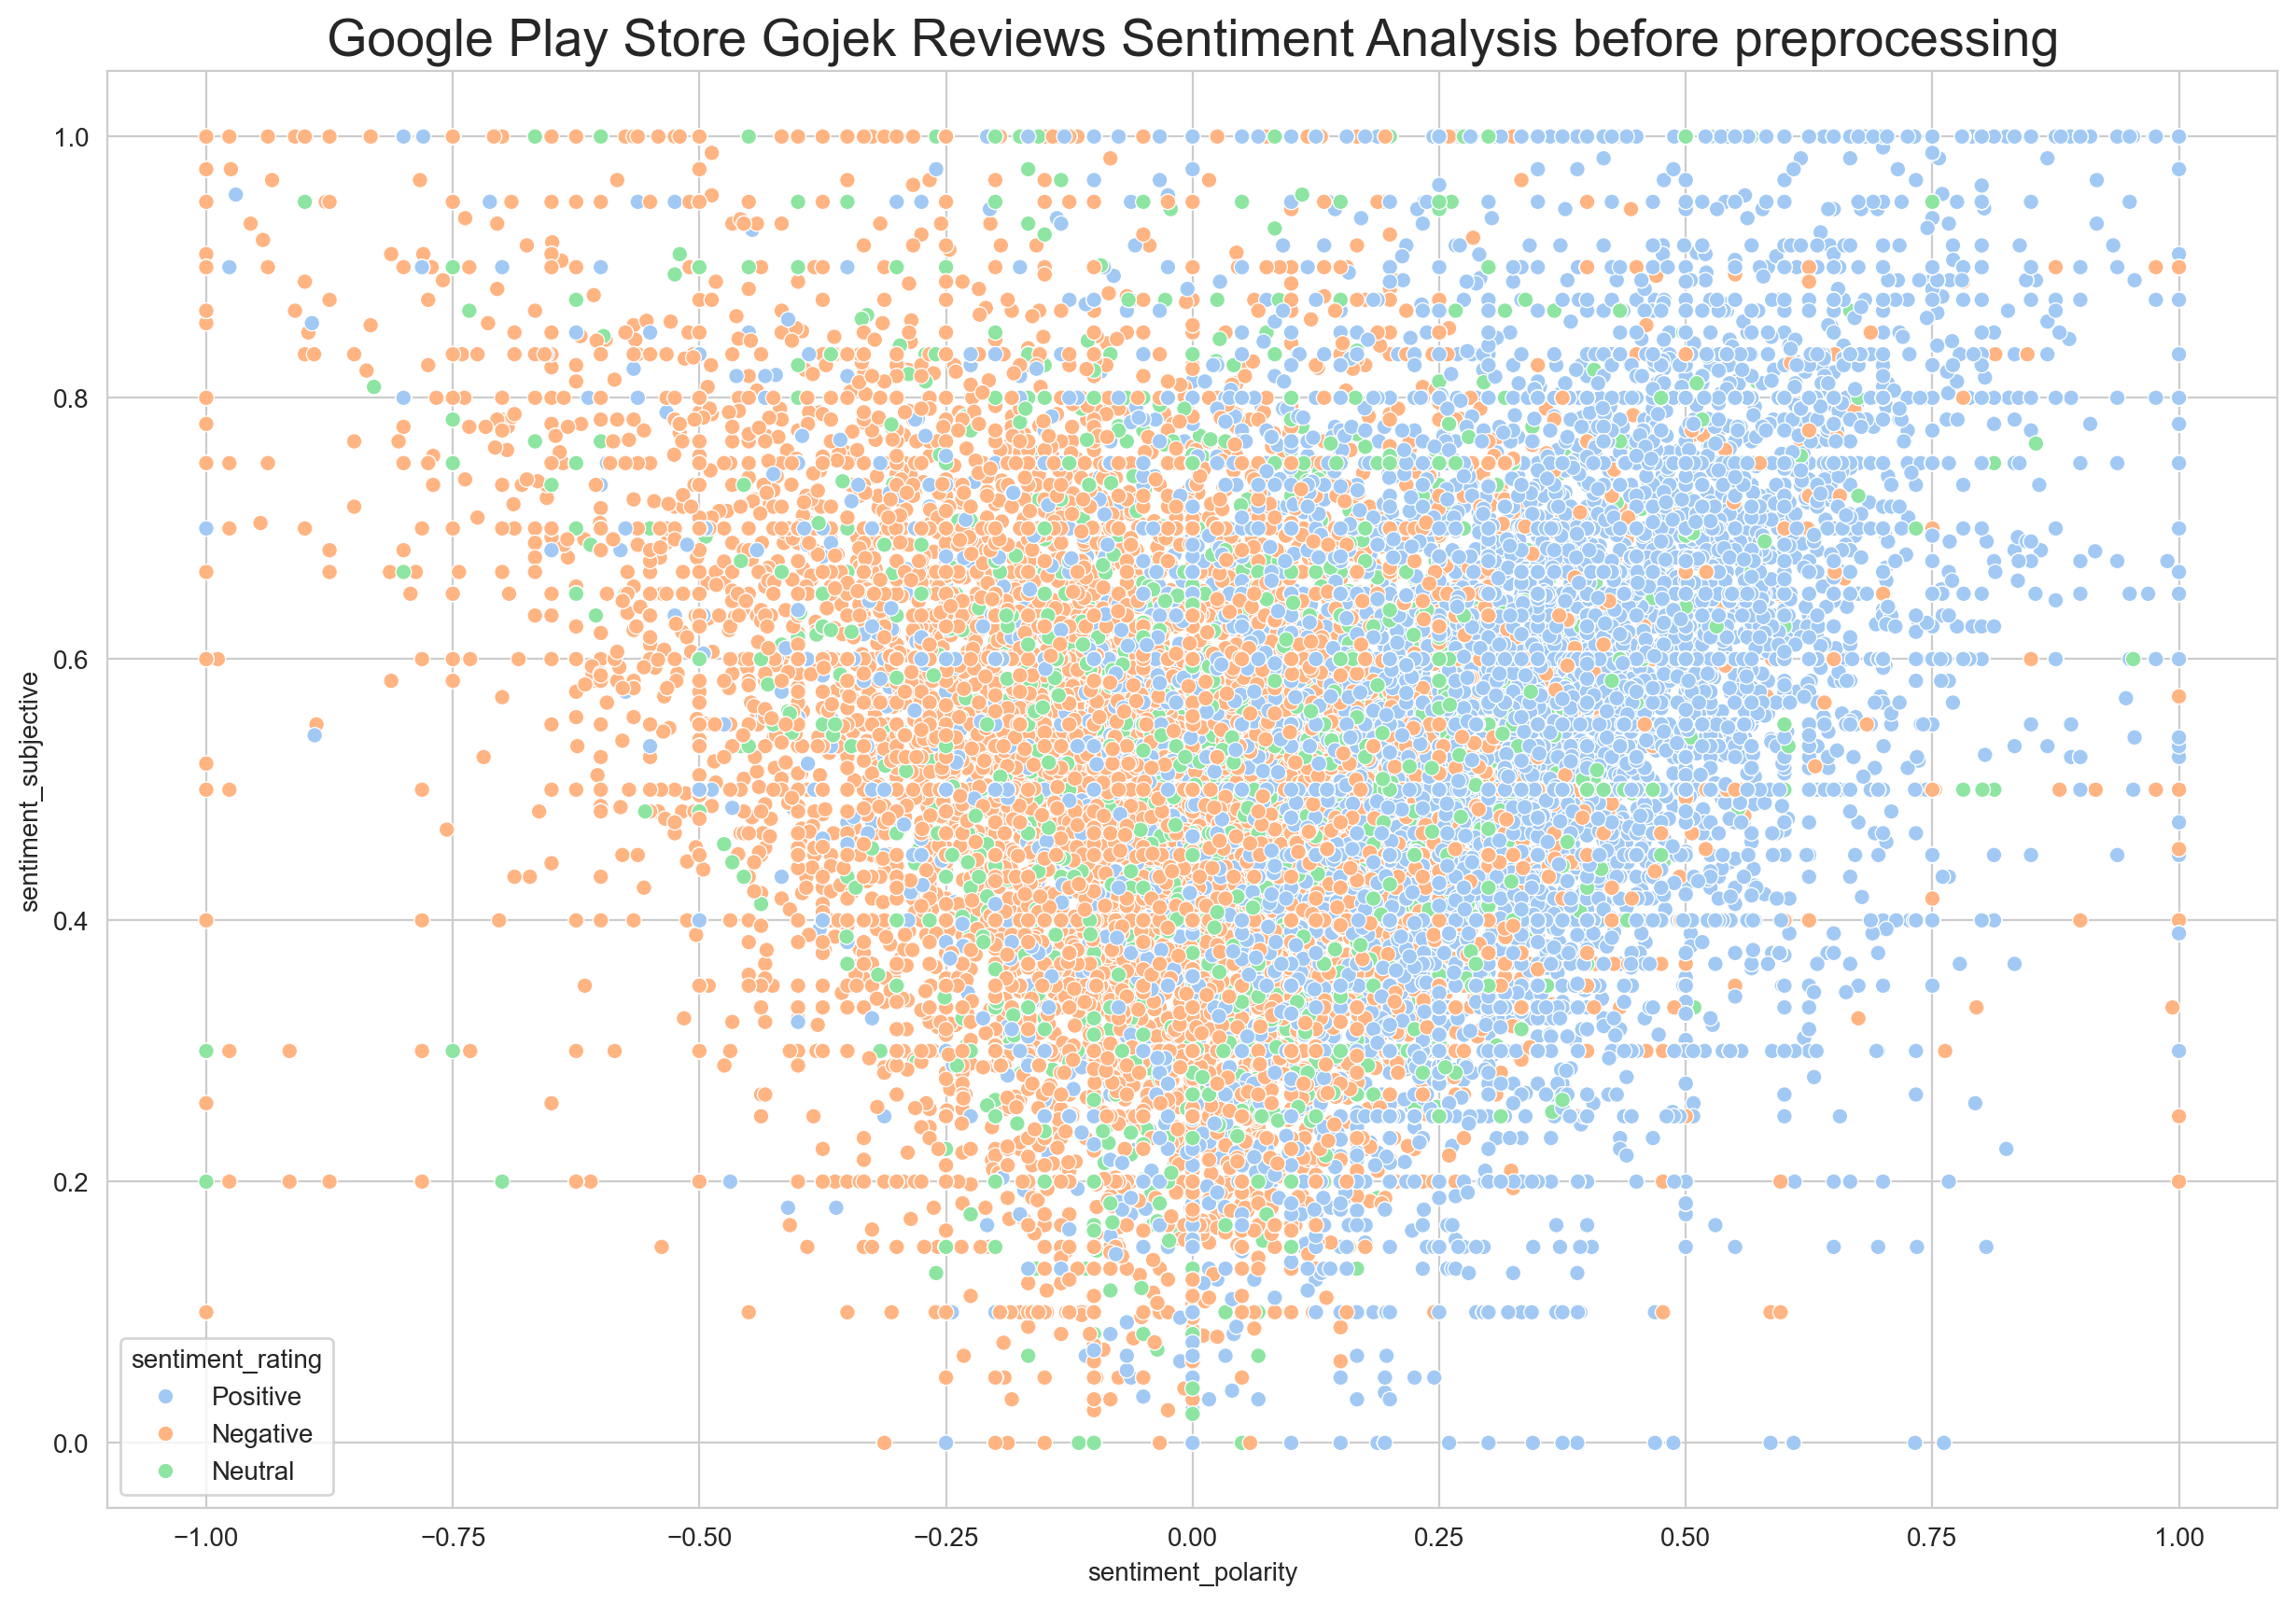

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis before preprocessing", fontsize=20)
plt.show()

In [10]:
!pip install emoji

You should consider upgrading via the 'C:\Users\PC GAMING\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [11]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

<h3>a. Lowercasing</h3>

In [12]:
# Lower casing
# Change the reviews type to string
df_gjkrev['content'] = df_gjkrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

cool!!!!!
Gojek should improve their maps. Please do it right away. The maps is only make drivers confused and lost. So annoying!
gopaylater tiba2 ga bisa pakai padahal bulan kemarin masih bisa pakai dan ga ada telat.sekarang malahan ga bisa pakai gopaylater


In [13]:
#Lowercase all reviews to see the difference
df_gjkrev['content']= df_gjkrev['content'].apply(lambda x: x.lower())
print(df_gjkrev['content'][188])
print(df_gjkrev['content'][1])
print(df_gjkrev['content'][20100])

cool!!!!!
gojek should improve their maps. please do it right away. the maps is only make drivers confused and lost. so annoying!
gopaylater tiba2 ga bisa pakai padahal bulan kemarin masih bisa pakai dan ga ada telat.sekarang malahan ga bisa pakai gopaylater


In [14]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

content  \
0                                                                                                                                                                                                still good app   
1                                                                                       gojek should improve their maps. please do it right away. the maps is only make drivers confused and lost. so annoying!   
2                                                                                                                                                                                price still higher than others   
3       the service is getting worse in 2025. food delivery takes very long and often very late. delivery drivers often cancel with no replacement. gojek offers voucher to make up for the late delivery bu...   
4                                                                                                                                                                                                         cukup   
...                                                                                                                                                                                                         ...   
226076                                                                                                                                                                                            love this app   
226077                                                                                                                                                                                    akhirnya keluar juga!   
226078                                                                                                                                                                                                  finally   
226079                                                                                                                                                                                                  helpful   
226080                                                                                                                                                                                           usefull banget   

        score  sentiment_polarity  sentiment_subjective  
0           5            0.700000              0.600000  
1           5           -0.278571              0.783929  
2           4            0.250000              0.500000  
3           2           -0.205625              0.535000  
4           2            0.000000              0.000000  
...       ...                 ...                   ...  
226076      5            0.500000              0.600000  
226077      5            0.000000              0.000000  
226078      5            0.000000              1.000000  
226079      4            0.000000              0.000000  
226080      5            0.000000              0.000000  

[226081 rows x 4 columns]

<h3>b. Stopwords Removal</h3>

In [15]:
!pip install Sastrawi

You should consider upgrading via the 'C:\Users\PC GAMING\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to C:\Users\PC
[nltk_data]     GAMING\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

df_gjkrev['wordCount'] = [len(review.split()) for review in df_gjkrev['content']]
df_gjkrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_gjkrev['content']]
df_gjkrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_gjkrev['content']]

In [18]:
# Assuming the text column is named 'text', update accordingly
text_column = 'content'  # Change this if the column has a different name

# Combine all text data into one string
all_text = ' '.join(df_gjkrev[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

In [19]:
df_gjkrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

content  \
0                                                                                                                                                                                                still good app   
1                                                                                       gojek should improve their maps. please do it right away. the maps is only make drivers confused and lost. so annoying!   
2                                                                                                                                                                                price still higher than others   
3       the service is getting worse in 2025. food delivery takes very long and often very late. delivery drivers often cancel with no replacement. gojek offers voucher to make up for the late delivery bu...   
4                                                                                                                                                                                                         cukup   
...                                                                                                                                                                                                         ...   
226076                                                                                                                                                                                            love this app   
226077                                                                                                                                                                                    akhirnya keluar juga!   
226078                                                                                                                                                                                                  finally   
226079                                                                                                                                                                                                  helpful   
226080                                                                                                                                                                                           usefull banget   

        score  sentiment_polarity  sentiment_subjective  wordCount  \
0           5            0.700000              0.600000          3   
1           5           -0.278571              0.783929         21   
2           4            0.250000              0.500000          5   
3           2           -0.205625              0.535000         53   
4           2            0.000000              0.000000          1   
...       ...                 ...                   ...        ...   
226076      5            0.500000              0.600000          3   
226077      5            0.000000              0.000000          3   
226078      5            0.000000              1.000000          1   
226079      4            0.000000              0.000000          1   
226080      5            0.000000              0.000000          2   

        uppercaseCharCount  specialCharCount  
0                        0                 0  
1                        0                 4  
2                        0                 0  
3                        0                 6  
4                        0                 0  
...                    ...               ...  
226076                   0                 0  
226077                   0                 1  
226078                   0                 0  
226079                   0                 0  
226080                   0                 0  

[226081 rows x 7 columns]

In [20]:
# Indonesian Stopword Removal using Sastrawi
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

sastrawi_stopwords = factory.get_stop_words()
print(f"There's total {len(sastrawi_stopwords)} Indonesian stopwords removed.")

There's total 126 Indonesian stopwords removed.


In [21]:
# English Stopword Removal using NLTK
# Get English stopwords
import nltk
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

# To get the number of English stopwords, use the len() function:
print(f"There's total {len(english_stopwords)} English stopwords removed.")


There's total 198 English stopwords removed.


[nltk_data] Downloading package stopwords to C:\Users\PC
[nltk_data]     GAMING\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Apply stopword removal to the 'content' column
df_gjkrev['content'] = df_gjkrev['content'].apply(lambda x: stopword_remover.remove(x))

<h3>c. Cleaning Text</h3>
(Include Stemming and Lemmatize)

In [23]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


# Create stemmer and lemmatizer objects
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\PC
[nltk_data]     GAMING\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\PC
[nltk_data]     GAMING\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
def cleaning_text(text):
  # Menambah spasi setelah koma pada koma yang tidak diberi spasi
  text = re.sub(r",(?!\s)", ", ", text)
  # menghapus special character
  text = re.sub(r'[^\w\s]', ' ', text)
  # Menghapus tab, new line, back slice, dll
  text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
  # Menghapus karakter non ASCII (emoticon, chinese word, dll),
  text = text.encode('ascii', 'replace').decode('ascii')
  # Menghapus URL
  text = re.sub(r"(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?", "", text)
  # Menghapus angka
  text = re.sub(r"\d+", "", text)
  # Menghapus tanda baca
  text = text.translate(str.maketrans("", "", string.punctuation))
  # Menghapus whitespace di depan/belakang teks dan double++ spasi
  text = text.strip()
  text = re.sub('\s+', ' ', text)
  # Menghapus single character
  text = re.sub(r"\b[a-zA-Z]\b", "", text)
  # stemming
  text = stemmer.stem(text)
  # lemmatize
  words = text.split()
  lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
  text = ' '.join(lemmatized_words)
  return text

In [25]:
df_gjkrev.loc[:, 'clean'] = df_gjkrev['content'].apply(cleaning_text)

# Display the first few rows of the DataFrame with the cleaned reviews
print("DataFrame with cleaned reviews (first 5 rows):")
display(df_gjkrev[['content', 'clean']].head())

DataFrame with cleaned reviews (first 5 rows):


content  \
0                                                                                                                                                                                           still good app   
1                                                                                  gojek should improve their maps. please do it right away. the maps is only make drivers confused and lost. so annoying!   
2                                                                                                                                                                           price still higher than others   
3  the service is getting worse in 2025. food delivery takes very long and often very late. delivery drivers often cancel with no replacement. gojek offers voucher to make up for the late delivery bu...   
4                                                                                                                                                                                                    cukup   

                                                                                                                                                                                                     clean  
0                                                                                                                                                                                           still good app  
1                                                                                            gojek should improve their map please do it right away the map be only make drivers confuse and lose so annoy  
2                                                                                                                                                                           price still higher than others  
3  the service be get worse in food delivery take very long and often very late delivery drivers often cancel with no replacement gojek offer voucher to make up for the late delivery but only if you ...  
4                                                                                                                                                                                                    cukup

<h2>#3 Hasil Review</h2>

<h3>a. Frequency Words</h3>

Word  Frequency
0      the      35185
1     good      29556
2       to      28084
3   driver      26723
4    gojek      24800
..     ...        ...
95     was       2978
96   harga       2918
97      or       2904
98    from       2903
99     get       2887

[100 rows x 2 columns]

C:\Users\PC GAMING\AppData\Local\Temp\ipykernel_8880\856327870.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


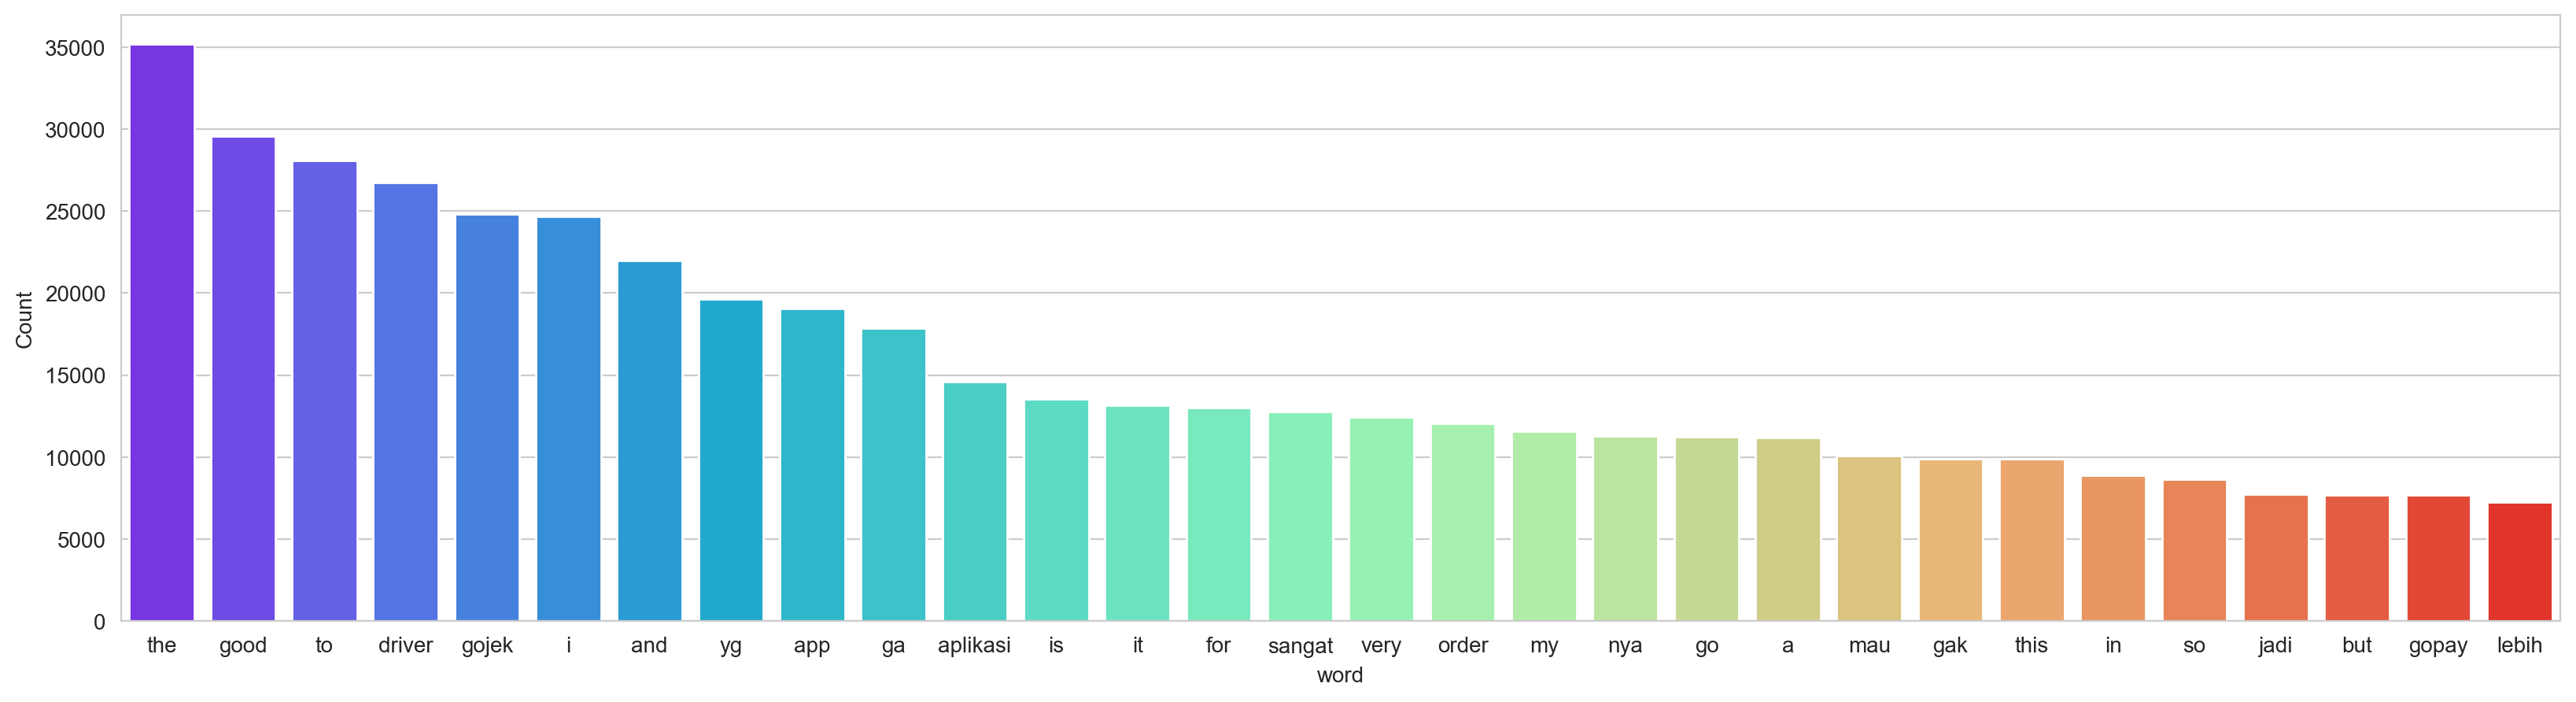

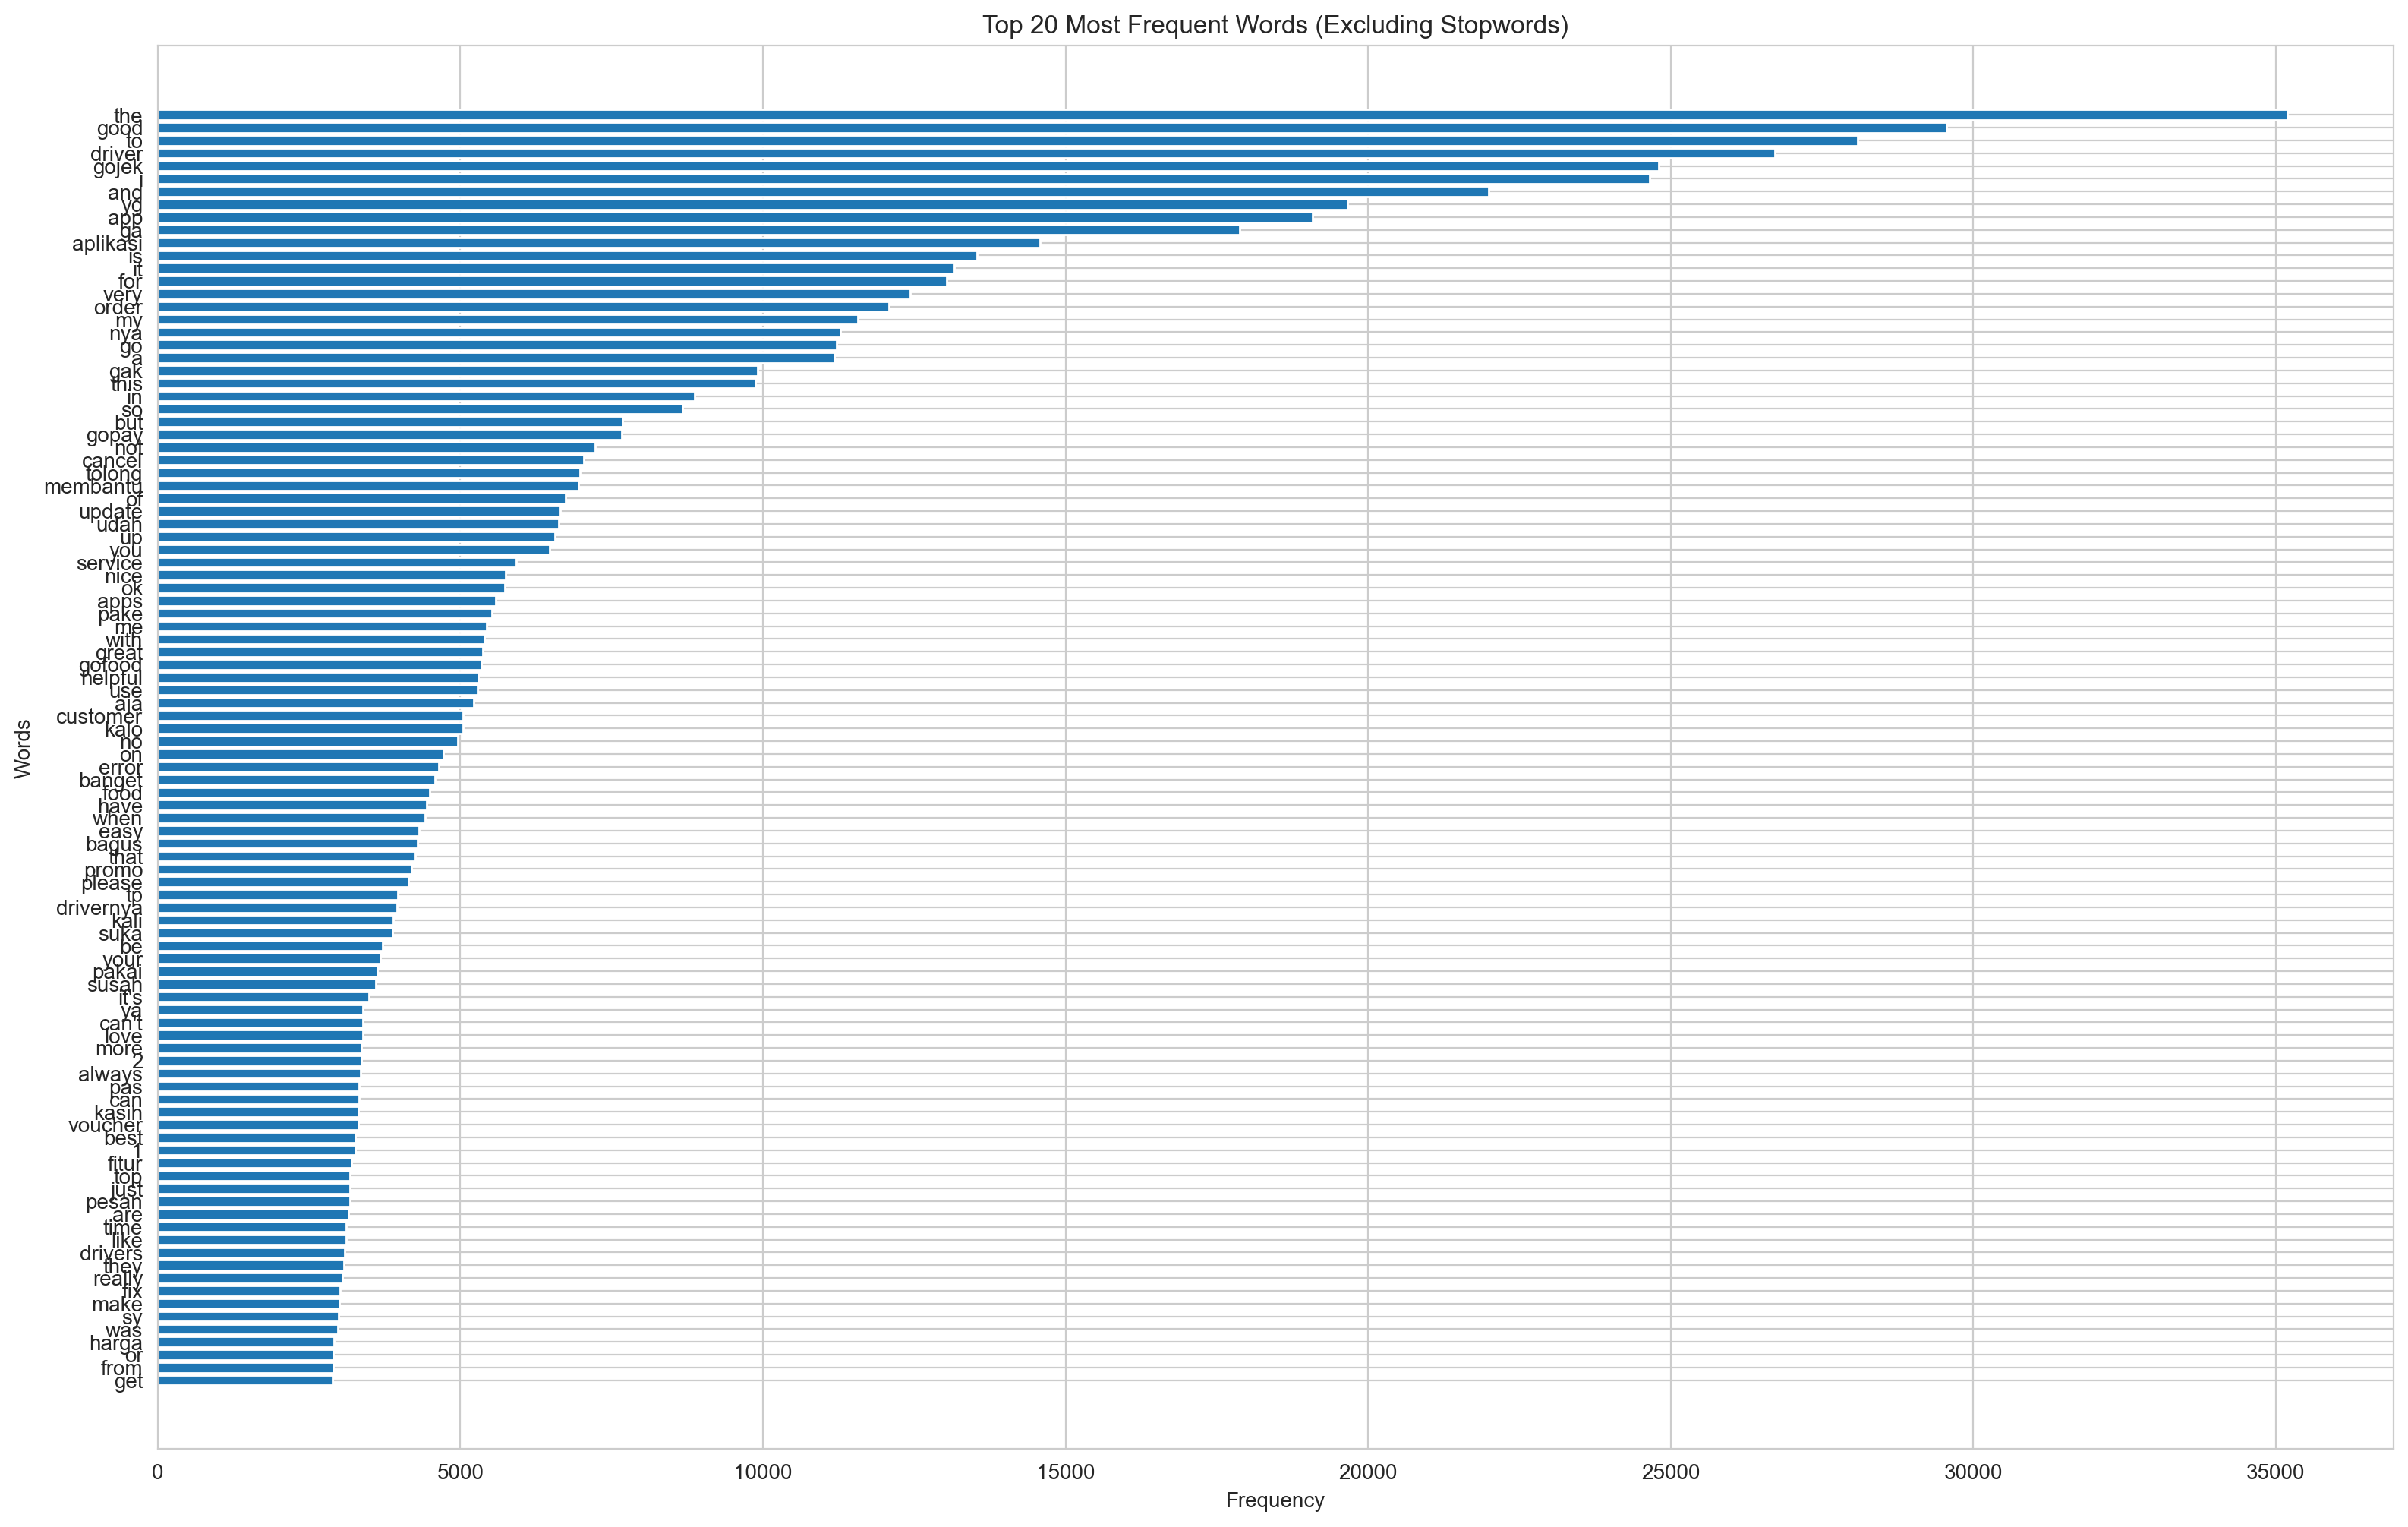

In [26]:
# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

# Plot the frequent words
freq_words(df_gjkrev['content'])
plt.figure(figsize=(19, 12))
plt.barh(word_freq_df['Word'][::-1], word_freq_df['Frequency'][::-1])
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.show()

<h3>c. Sentiment Analysis after Preprocessing</h3>

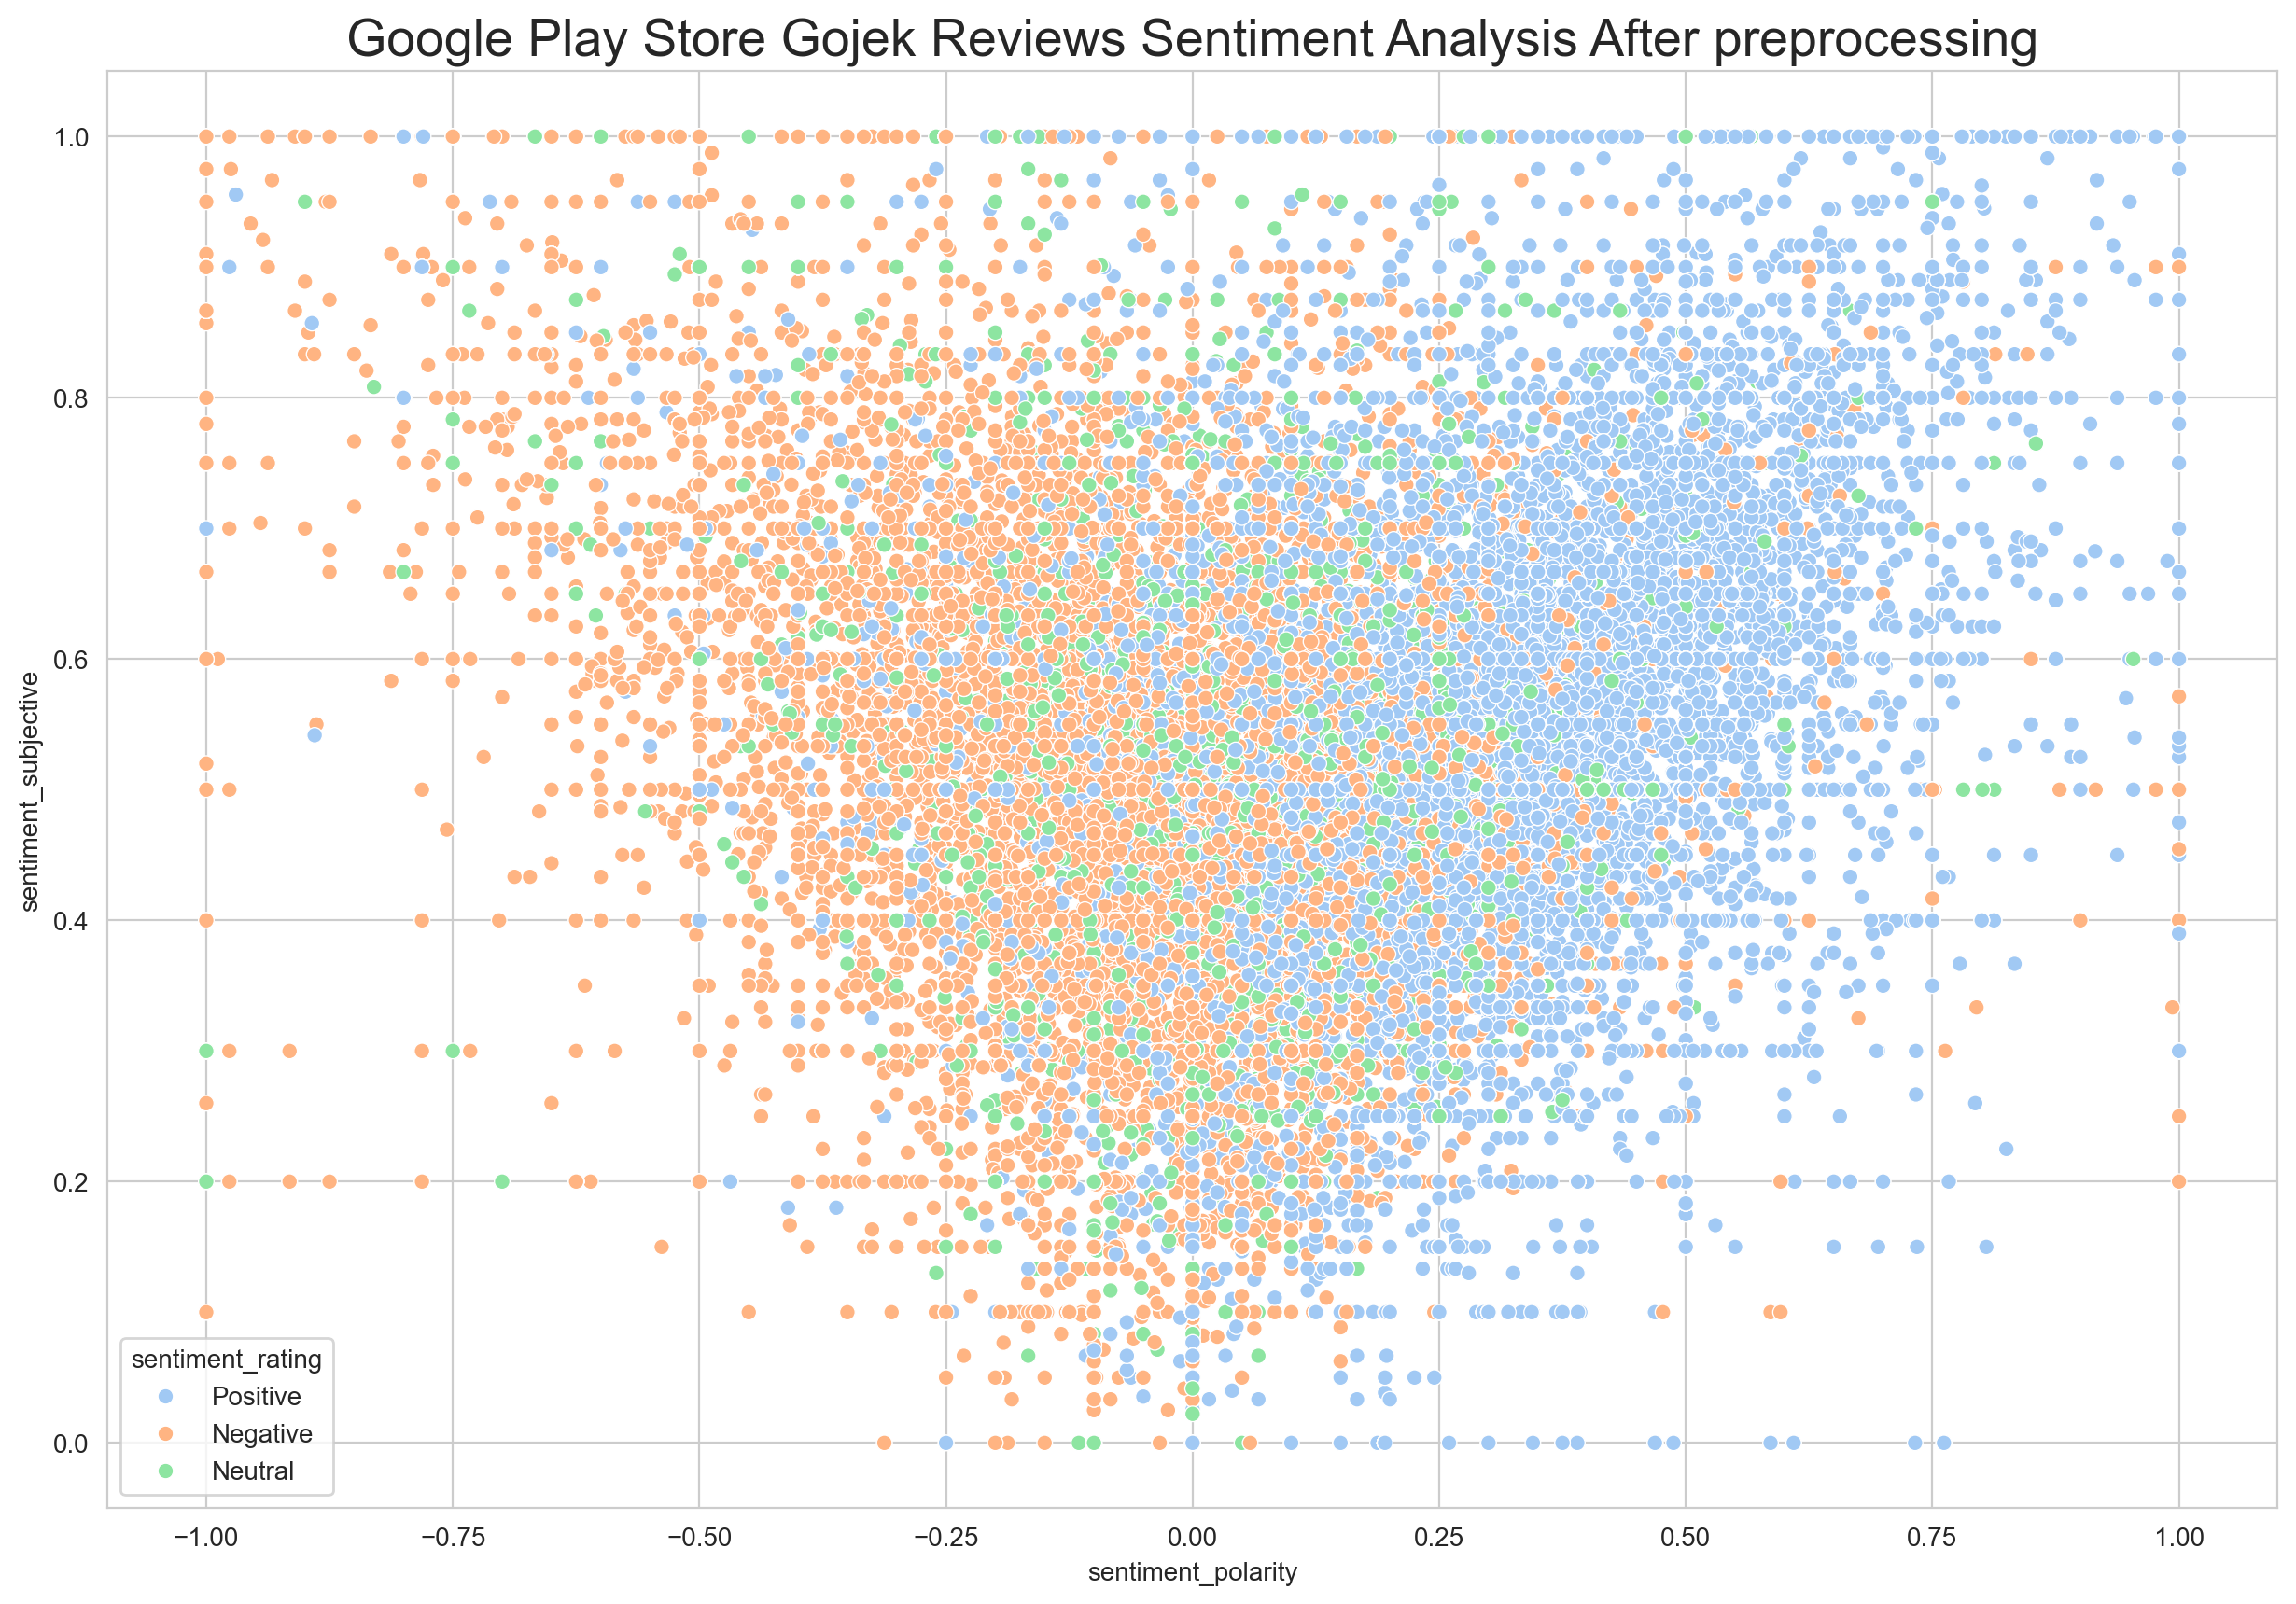

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_gjkrev['sentiment_polarity'], y=df_gjkrev['sentiment_subjective'],
                hue=df_gjkrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store Gojek Reviews Sentiment Analysis After preprocessing", fontsize=20)
plt.show()

In [28]:
# Save the cleaned DataFrame to a new CSV file
df_gjkrev.to_csv(r'data/df_gjkrev.csv', index=False)